# Electric Vehicle Price Forecast

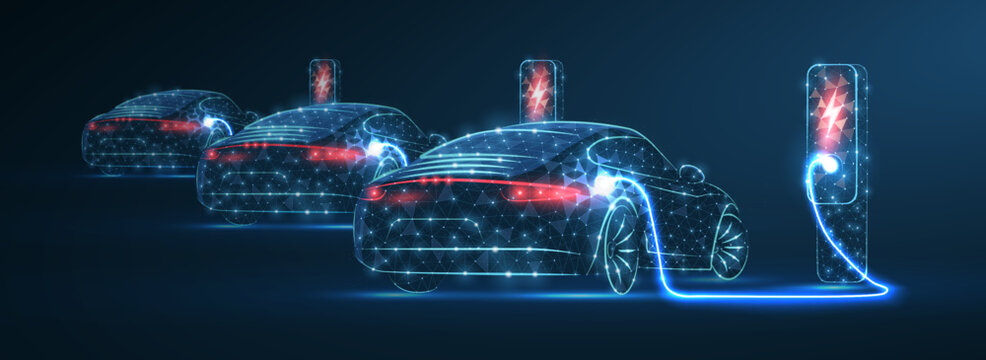

### Gerekli kütüphaneleri yükleme

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import random


### Veri setini yükleme

In [2]:
data = pd.read_csv('ElectricVehicle.csv')

### Sütun adlarını kontrol etme

In [3]:
print(data.columns)

Index(['Battery', 'Car_name', 'Car_name_link', 'Efficiency', 'Fast_charge',
       'Price.DE.', 'Range', 'Top_speed', 'acceleration..0.100.'],
      dtype='object')


### Veri keşfi ve görselleştirme

D:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


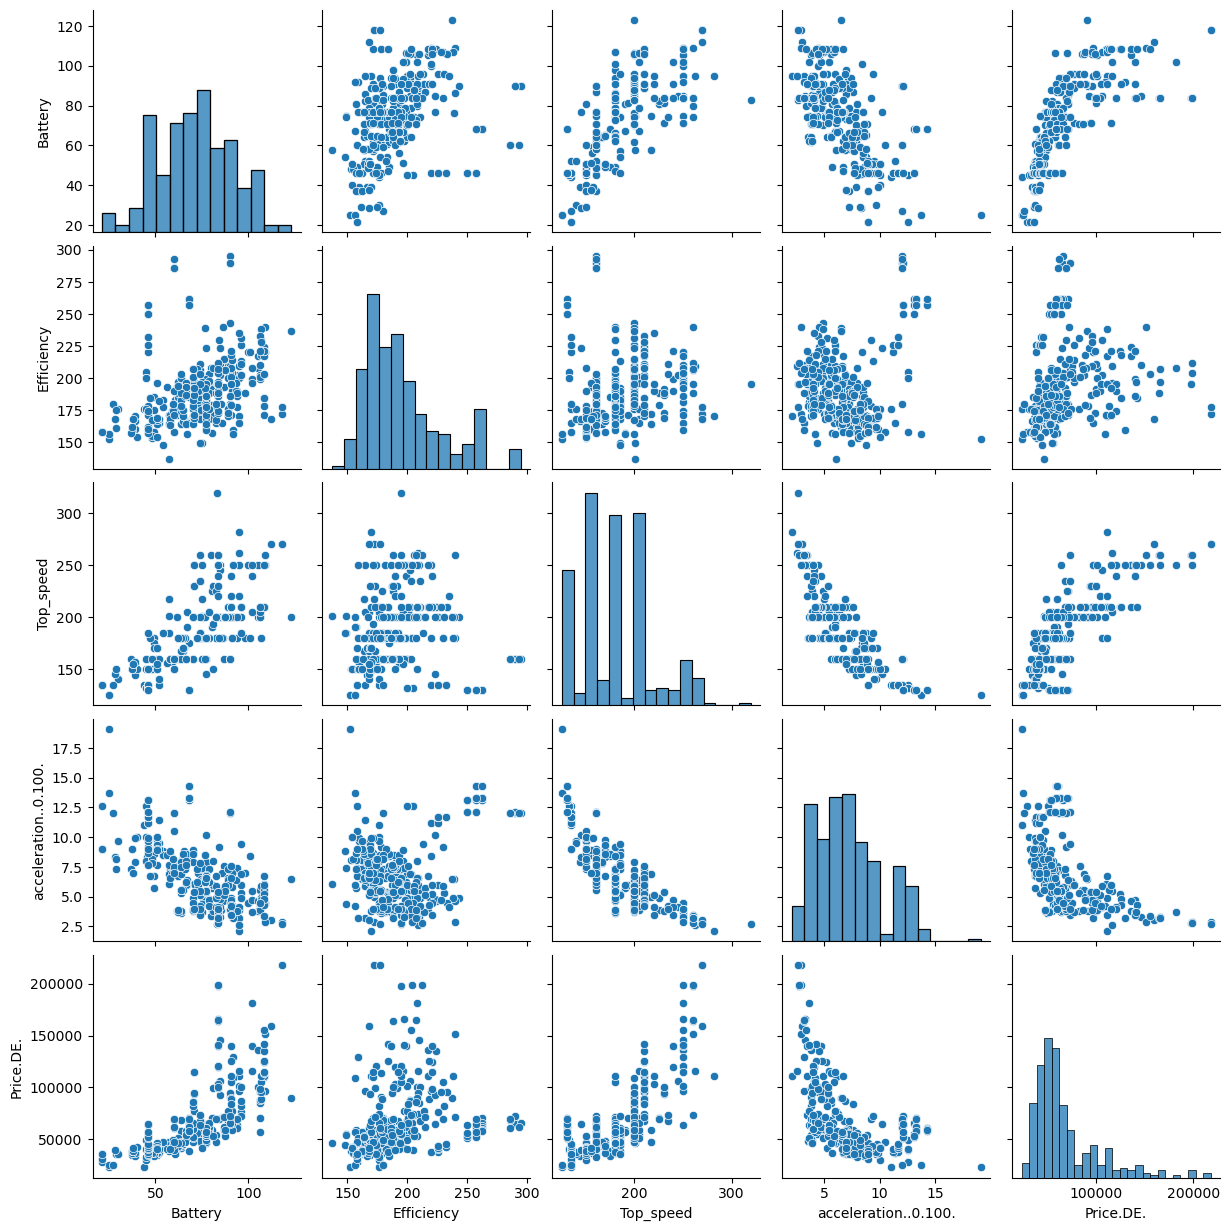

In [4]:
sns.pairplot(data[['Battery', 'Efficiency', 'Top_speed', 'acceleration..0.100.', 'Price.DE.']])  
plt.show()

### Hedef değişkenin dağılımını gösteren görselleştirmeler

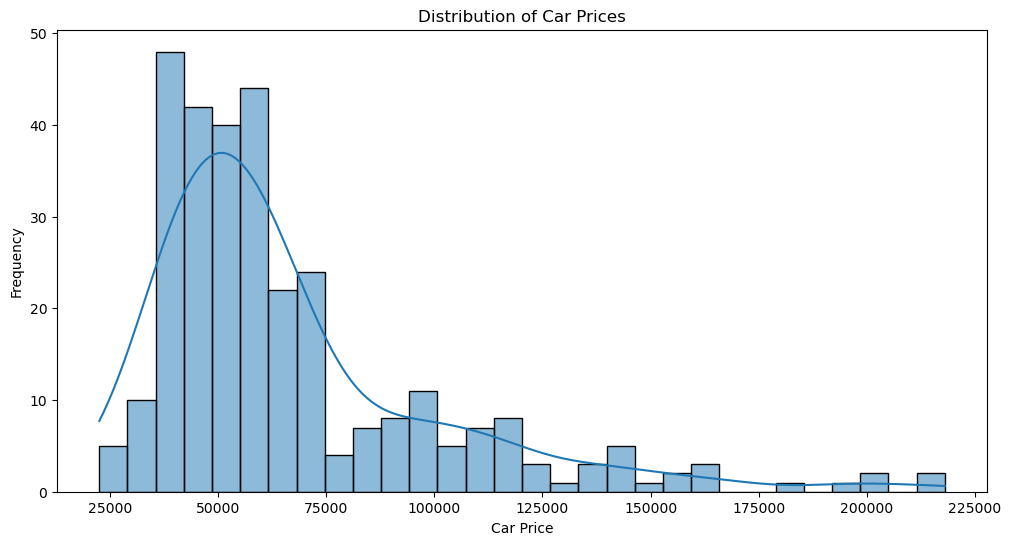

In [5]:
plt.figure(figsize=(12, 6))
if 'Price.DE.' in data.columns:
    sns.histplot(data['Price.DE.'], bins=30, kde=True)
    plt.title('Distribution of Car Prices')
    plt.xlabel('Car Price')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Price sütunu bulunamadı.")

### Eksik değerlere sahip örnekleri kaldırma

In [6]:
if 'Price.DE.' in data.columns:
    data = data.dropna(subset=['Price.DE.'])
else:
    print("Price sütunu bulunamadı.")

### Kategorik değişkenleri çıkartma

In [7]:
data = data.drop(columns=['Car_name', 'Car_name_link'], axis=1)

### Özellik adlarını düzenleme

In [8]:
data = data.rename(columns={'Fast_charge': 'FastCharge',
                            'Price.DE.': 'Price',
                            'Top_speed': 'TopSpeed',
                            'acceleration..0.100.': 'AccelerationTime'})


### Korelasyon matrisini görselleştirme

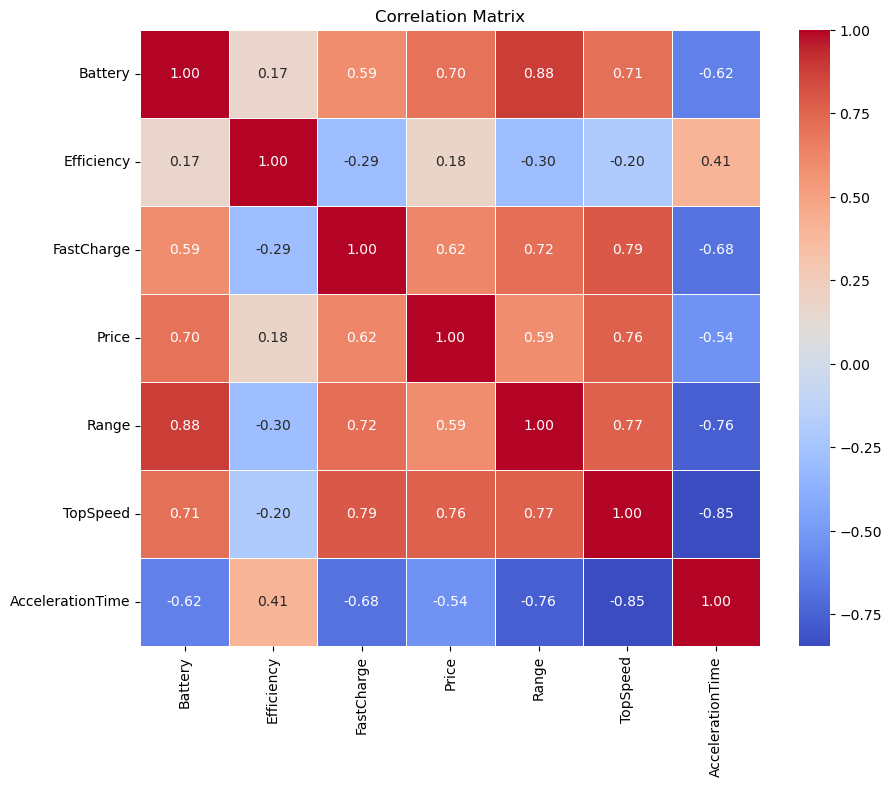

In [9]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

### Model değerlendirme fonksiyonunu tanımlama

In [12]:
def model_evaluation(X, y, clf, tag):
    y_pred = clf.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)
    
    metrics = [r2, mse, rmse, mae]
    metrics_name = ['R-Square', 'MSE', 'RMSE', 'MAE']
    
    res = pd.DataFrame(metrics, columns=[tag], index=metrics_name)
    
    return res

### Veri setini eğitim ve test setlerine ayırma

In [13]:
train, test = train_test_split(data, test_size=0.2, random_state=122)

X_train = train.drop(columns=['Price'], axis=1)
y_train = train['Price']

X_test = test.drop(columns=['Price'], axis=1)
y_test = test['Price']

### Veri ön işleme

In [14]:
pipe = Pipeline([('imputation', SimpleImputer(strategy='mean')),
                 ('scaler', MinMaxScaler())])

X_train_processed = pipe.fit_transform(X_train)
X_test_processed = pipe.transform(X_test)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

### Gradient Boosting Regressor modelini eğitme

In [15]:
gradient_boosting = GradientBoostingRegressor()

param_grid_gradient_boosting = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gradient_boosting = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid_gradient_boosting, scoring='neg_mean_squared_error', cv=5)
grid_search_gradient_boosting.fit(X_train_processed, y_train_log)
best_gradient_boosting = grid_search_gradient_boosting.best_estimator_

### Support Vector Regression (SVR) modelini eğitme

In [16]:
svr = SVR()

param_grid_svr = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, scoring='neg_mean_squared_error', cv=5)
grid_search_svr.fit(X_train_processed, y_train_log)
best_svr = grid_search_svr.best_estimator_

### ElasticNet modelini eğitme

In [17]:
elastic_net = ElasticNet()

param_grid_elastic_net = {
    'alpha': [0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

grid_search_elastic_net = GridSearchCV(estimator=elastic_net, param_grid=param_grid_elastic_net, scoring='neg_mean_squared_error', cv=5)
grid_search_elastic_net.fit(X_train_processed, y_train_log)
best_elastic_net = grid_search_elastic_net.best_estimator_

### Modelleri değerlendirme

In [18]:
gradient_boosting_res = model_evaluation(X_test_processed, y_test_log, best_gradient_boosting, 'Gradient Boosting')
svr_res = model_evaluation(X_test_processed, y_test_log, best_svr, 'SVR')
elastic_net_res = model_evaluation(X_test_processed, y_test_log, best_elastic_net, 'ElasticNet')

models_performance = pd.concat([gradient_boosting_res, svr_res, elastic_net_res], axis=1)

### Gerçek ve tahmin değerlerini karşılaştırmak için scatter plot

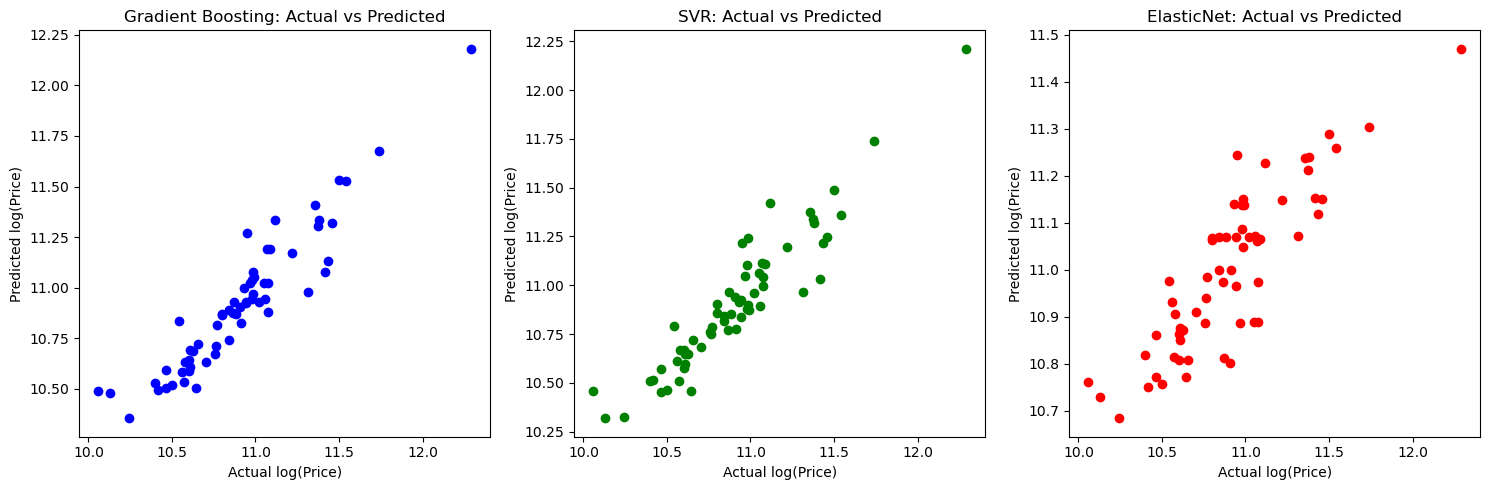

,Gradient Boosting,SVR,ElasticNet
R-Square,0.874556,0.876074,0.506563
MSE,0.019003,0.018773,0.074749
RMSE,0.137852,0.137016,0.273403
MAE,0.097602,0.097337,0.225060


In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_log, best_gradient_boosting.predict(X_test_processed), color='blue')
plt.title('Gradient Boosting: Actual vs Predicted')
plt.xlabel('Actual log(Price)')
plt.ylabel('Predicted log(Price)')

plt.subplot(1, 3, 2)
plt.scatter(y_test_log, best_svr.predict(X_test_processed), color='green')
plt.title('SVR: Actual vs Predicted')
plt.xlabel('Actual log(Price)')
plt.ylabel('Predicted log(Price)')

plt.subplot(1, 3, 3)
plt.scatter(y_test_log, best_elastic_net.predict(X_test_processed), color='red')
plt.title('ElasticNet: Actual vs Predicted')
plt.xlabel('Actual log(Price)')
plt.ylabel('Predicted log(Price)')

plt.tight_layout()
plt.show()

display(models_performance)

### Rastgele 3 örnek seçme

In [54]:
random_indices = random.sample(range(len(X_test_processed)), 3)

### Seçilen örneklerin gerçek ve tahmin edilen değerleri

In [55]:
for i, index in enumerate(random_indices):
    actual_price = y_test_log.iloc[index]
    
    # Gradient Boosting Tahmin
    gb_prediction = best_gradient_boosting.predict(X_test_processed[index].reshape(1, -1))[0]
    
    # SVR Tahmin
    svr_prediction = best_svr.predict(X_test_processed[index].reshape(1, -1))[0]
    
    # ElasticNet Tahmin
    en_prediction = best_elastic_net.predict(X_test_processed[index].reshape(1, -1))[0]
    
    print(f"Örnek {i + 1} - İndeks: {index}")
    print(f"\nGerçek Fiyat : {actual_price}")
    print(f"Gradient Boosting Tahmini Fiyat : {gb_prediction}")
    print(f"SVR Tahmini Fiyat : {svr_prediction}")
    print(f"ElasticNet Tahmini Fiyat : {en_prediction}")
    print("\n")


Örnek 1 - İndeks: 16

Gerçek Fiyat : 10.757902880692196
Gradient Boosting Tahmini Fiyat : 10.669884275345058
SVR Tahmini Fiyat : 10.758041980983185
ElasticNet Tahmini Fiyat : 10.886482097876964


Örnek 2 - İndeks: 20

Gerçek Fiyat : 11.050731262615974
Gradient Boosting Tahmini Fiyat : 11.025256443627661
SVR Tahmini Fiyat : 11.063936897274953
ElasticNet Tahmini Fiyat : 10.889521975026144


Örnek 3 - İndeks: 51

Gerçek Fiyat : 11.35392973347977
Gradient Boosting Tahmini Fiyat : 11.406473556213168
SVR Tahmini Fiyat : 11.37441291788764
ElasticNet Tahmini Fiyat : 11.238964877148266


